# Transfer Learning - VGG16PART - Multiclass Classification- Covid Detection

## Prepare In Google Colab

In [1]:
!pip install jcopdl
!pip install gdown

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=d2b89cf841cbd46ff2ffecddad7038f2116fe72219e55675be0bab5ac0ed13b1
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [2]:
!gdown https://drive.google.com/uc?id=1fNwR_v3_IvwOiPZRYMEm3DJtITxrnhJi

Downloading...
From: https://drive.google.com/uc?id=1fNwR_v3_IvwOiPZRYMEm3DJtITxrnhJi
To: /content/Datasets-Covid-MultiClassTF.zip
645MB [00:06, 95.3MB/s]


In [3]:
!unzip /content/Datasets-Covid-MultiClassTF.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (155).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (156).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (157).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (158).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (159).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (16).jpeg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (16).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (160).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (161).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (162).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (163).jpg  
  inflating: Datasets-Covid-MultiClassTF/test/Covid-19/COVID-19 (164).jpg  
  inflating: Datasets-Covid-Mu

## Import Package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import itertools
import os
import torchvision
from torchsummary import summary
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from jcopdl.layers import linear_block, conv_block
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset dan Dataloader

In [3]:
bs = 128
crop_size = 224 #harus sama dgn pre-train (transfer learning)

train_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(335),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("/content/Datasets-Covid-MultiClassTF/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/Datasets-Covid-MultiClassTF/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

val_set = datasets.ImageFolder("/content/Datasets-Covid-MultiClassTF/val/", transform=val_transform)
valloader = DataLoader(val_set, batch_size=bs, shuffle=True)

## Exploratory Data Analysis (EDA)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


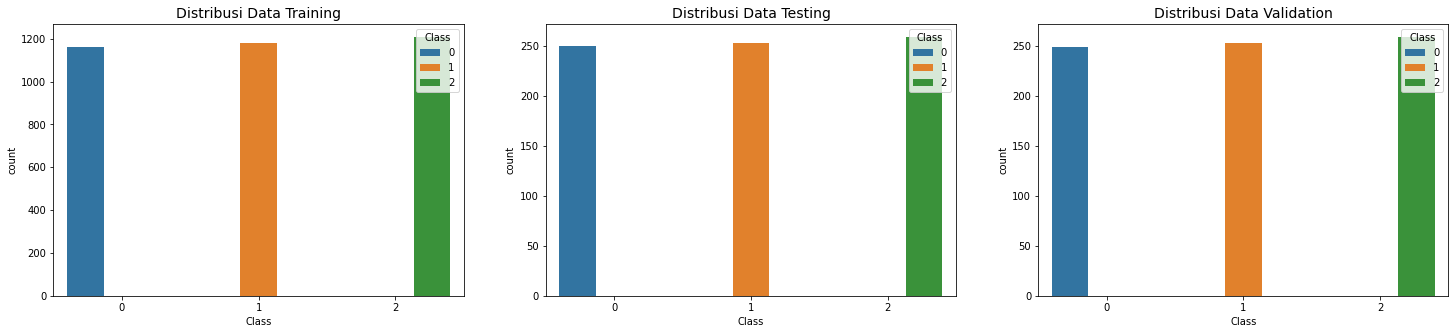

In [4]:
train = pd.DataFrame(train_set.samples,  columns=['Images', 'Class'])
test = pd.DataFrame(test_set.samples,  columns=['Images', 'Class'])
val = pd.DataFrame(val_set.samples,  columns=['Images', 'Class'])

plt.figure(figsize=(25, 5))

plt.subplot(131)
sns.countplot('Class', data=train, hue='Class');
plt.title('Distribusi Data Training', fontsize=14);

plt.subplot(132)
sns.countplot('Class', data=test, hue='Class');
plt.title('Distribusi Data Testing', fontsize=14);

plt.subplot(133)
sns.countplot('Class', data=val, hue='Class');
plt.title('Distribusi Data Validation', fontsize=14);

In [5]:
label2cat = train_set.classes
label2cat

['Covid-19', 'Normal', 'Pneumonia']

In [6]:
#cek
loader = iter(trainloader)
images, labels = next(loader)
images.shape

torch.Size([128, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

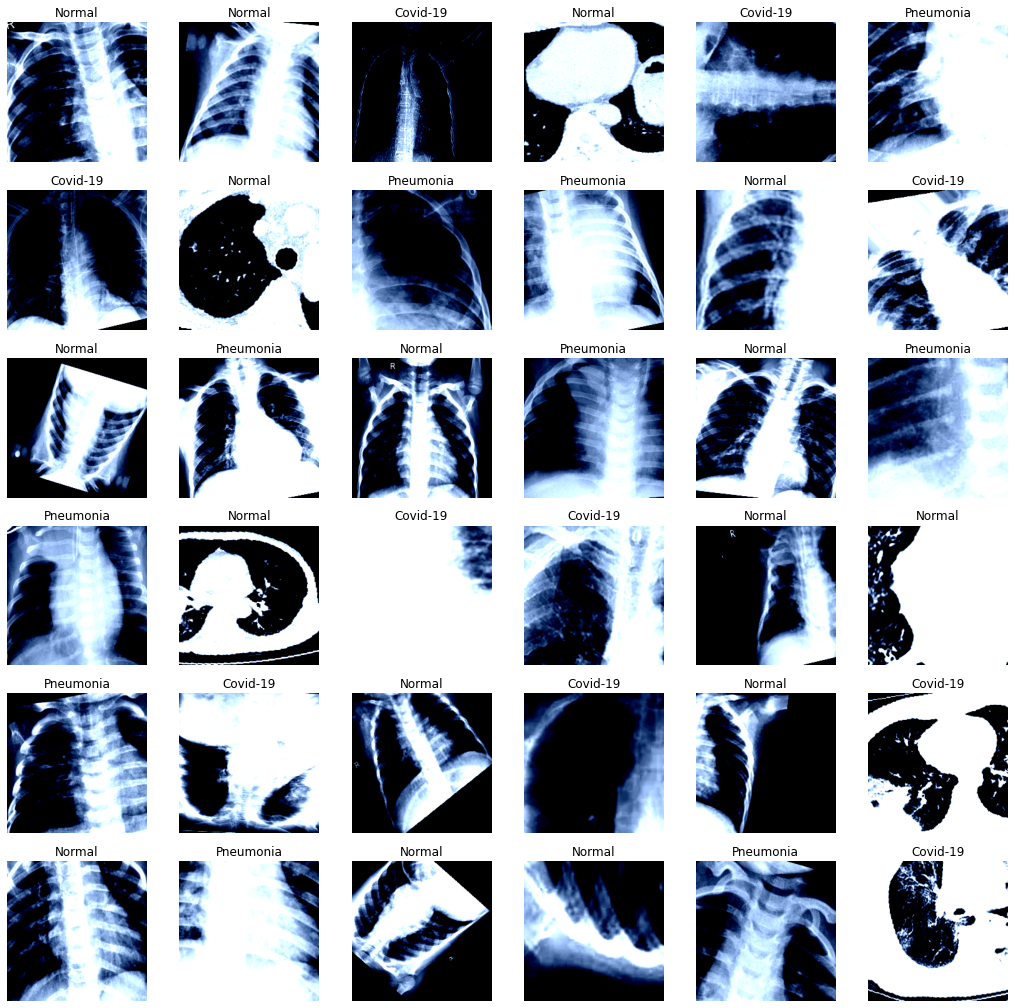

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    label = label2cat[label.item()]
    ax.set_title(f"{label}")
    ax.axis('off');

## Arsitektur dan Config

In [10]:
from torchvision.models import vgg16

In [9]:
# from torchvision.models import vgg16

# vgg16 = vgg16() #download weight dari vgg16
# for name, child in vgg16.named_children():
#     print(name)

features
avgpool
classifier


In [23]:
vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [65]:
class CustomVGG16(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        
        self.vgg16 = vgg16(pretrained=True) #download weight dari vgg16
        
        self.freeze()
        
        #ubah dan reset fully connectednya saja (fc)
        self.vgg16.classifier = nn.Sequential(
            
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(4096, output_size),
            nn.LogSoftmax(dim=1) 
        )
        
    def forward(self, x):
        return self.vgg16(x)
               
    def freeze(self):
        #frezee weight dan arsitekturnya
        for param in self.vgg16.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        #unfreeze weight dan arsitekturnya
        for param in self.vgg16.features[24:30].parameters():
            param.requires_grad = True
            
        

In [66]:
config = set_config ({
  
    "output_size" : 3,
    "batch_size" : bs,
    "crop_size" : crop_size
      
})

## Training Preparation (MCOC) and Training 

### Phase 1 : Adaptation (Learning rate standard + patience kecil)

In [67]:
model = CustomVGG16(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="VGG16-Covid", early_stop_patience=2)

In [68]:
parameter = summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,



Epoch     1
Train_cost  = 3.0711 | Test_cost  = 0.3650 | Train_score = 0.6114 | Test_score = 0.8371 |




Epoch     2
Train_cost  = 0.3912 | Test_cost  = 0.3469 | Train_score = 0.8296 | Test_score = 0.8463 |




Epoch     3
Train_cost  = 0.3340 | Test_cost  = 0.2641 | Train_score = 0.8617 | Test_score = 0.8962 |




Epoch     4
Train_cost  = 0.2982 | Test_cost  = 0.2721 | Train_score = 0.8750 | Test_score = 0.8870 |
==> EarlyStop patience =  1 | Best test_score: 0.8962




Epoch     5
Train_cost  = 0.3004 | Test_cost  = 0.2360 | Train_score = 0.8674 | Test_score = 0.8975 |




Epoch     6
Train_cost  = 0.2757 | Test_cost  = 0.2366 | Train_score = 0.8862 | Test_score = 0.8949 |
==> EarlyStop patience =  1 | Best test_score: 0.8975




Epoch     7
Train_cost  = 0.2619 | Test_cost  = 0.2227 | Train_score = 0.8843 | Test_score = 0.9093 |




Epoch     8
Train_cost  = 0.2666 | Test_cost  = 0.2298 | Train_score = 0.8902 | Test_score = 0.9028 |
==> EarlyStop patience =  1 | Best test_score: 0.9093




Epoch     9
Train_cost  = 0.2632 | Test_cost  = 0.2201 | Train_score = 0.8871 | Test_score = 0.9120 |




Epoch    10
Train_cost  = 0.2677 | Test_cost  = 0.2172 | Train_score = 0.8862 | Test_score = 0.9185 |




Epoch    11
Train_cost  = 0.2527 | Test_cost  = 0.2357 | Train_score = 0.8936 | Test_score = 0.9106 |
==> EarlyStop patience =  1 | Best test_score: 0.9185




Epoch    12
Train_cost  = 0.2321 | Test_cost  = 0.2055 | Train_score = 0.9003 | Test_score = 0.9172 |
==> EarlyStop patience =  2 | Best test_score: 0.9185
==> Execute Early Stopping at epoch: 12 | Best test_score: 0.9185
==> Best model is saved at VGG16-Covid


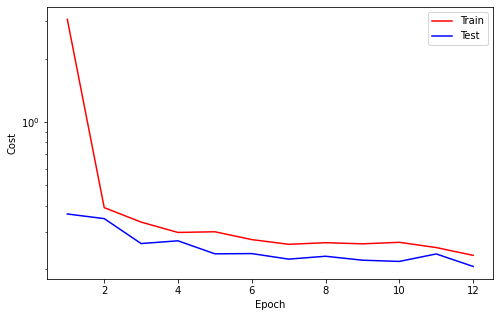

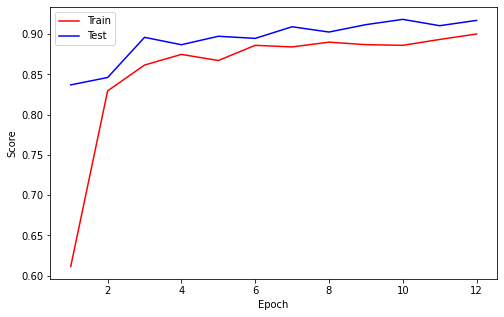

In [69]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()
        
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("val", val_set, valloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

### Phase 2 : Fine-tuning (learning rate kecil dan patience standard)

In [70]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
callback.reset_early_stop()
callback.early_stop_patience=5

In [71]:
parameter = summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,



Epoch    13
Train_cost  = 0.2054 | Test_cost  = 0.1951 | Train_score = 0.9164 | Test_score = 0.9185 |
==> EarlyStop patience =  1 | Best test_score: 0.9185




Epoch    14
Train_cost  = 0.1988 | Test_cost  = 0.1920 | Train_score = 0.9169 | Test_score = 0.9238 |




Epoch    15
Train_cost  = 0.1939 | Test_cost  = 0.1842 | Train_score = 0.9147 | Test_score = 0.9198 |
==> EarlyStop patience =  1 | Best test_score: 0.9238




Epoch    16
Train_cost  = 0.1827 | Test_cost  = 0.1892 | Train_score = 0.9200 | Test_score = 0.9212 |
==> EarlyStop patience =  2 | Best test_score: 0.9238




Epoch    17
Train_cost  = 0.1817 | Test_cost  = 0.1958 | Train_score = 0.9228 | Test_score = 0.9185 |
==> EarlyStop patience =  3 | Best test_score: 0.9238




Epoch    18
Train_cost  = 0.1777 | Test_cost  = 0.1860 | Train_score = 0.9288 | Test_score = 0.9225 |
==> EarlyStop patience =  4 | Best test_score: 0.9238




Epoch    19
Train_cost  = 0.1771 | Test_cost  = 0.1746 | Train_score = 0.9257 | Test_score = 0.9251 |




Epoch    20
Train_cost  = 0.1747 | Test_cost  = 0.1952 | Train_score = 0.9273 | Test_score = 0.9212 |


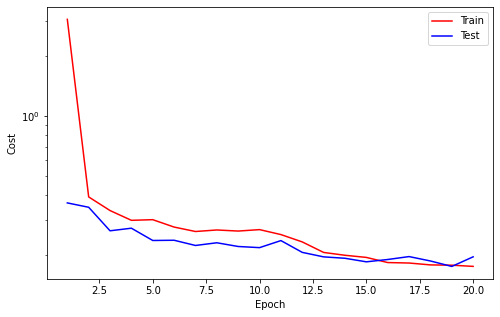

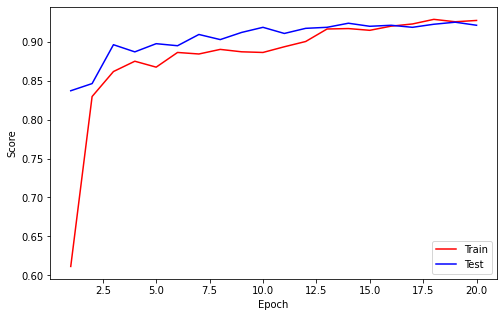

==> EarlyStop patience =  1 | Best test_score: 0.9251




Epoch    21
Train_cost  = 0.1598 | Test_cost  = 0.1836 | Train_score = 0.9375 | Test_score = 0.9304 |




Epoch    22
Train_cost  = 0.1588 | Test_cost  = 0.1850 | Train_score = 0.9364 | Test_score = 0.9264 |
==> EarlyStop patience =  1 | Best test_score: 0.9304




Epoch    23
Train_cost  = 0.1718 | Test_cost  = 0.1751 | Train_score = 0.9276 | Test_score = 0.9317 |




Epoch    24
Train_cost  = 0.1580 | Test_cost  = 0.1772 | Train_score = 0.9335 | Test_score = 0.9330 |




Epoch    25
Train_cost  = 0.1597 | Test_cost  = 0.1831 | Train_score = 0.9411 | Test_score = 0.9304 |
==> EarlyStop patience =  1 | Best test_score: 0.9330




Epoch    26
Train_cost  = 0.1564 | Test_cost  = 0.1785 | Train_score = 0.9375 | Test_score = 0.9343 |




Epoch    27
Train_cost  = 0.1488 | Test_cost  = 0.1676 | Train_score = 0.9364 | Test_score = 0.9290 |
==> EarlyStop patience =  1 | Best test_score: 0.9343




Epoch    28
Train_cost  = 0.1495 | Test_cost  = 0.1676 | Train_score = 0.9400 | Test_score = 0.9290 |
==> EarlyStop patience =  2 | Best test_score: 0.9343




Epoch    29
Train_cost  = 0.1366 | Test_cost  = 0.1704 | Train_score = 0.9456 | Test_score = 0.9290 |
==> EarlyStop patience =  3 | Best test_score: 0.9343




Epoch    30
Train_cost  = 0.1330 | Test_cost  = 0.1789 | Train_score = 0.9448 | Test_score = 0.9277 |
==> EarlyStop patience =  4 | Best test_score: 0.9343




Epoch    31
Train_cost  = 0.1516 | Test_cost  = 0.1841 | Train_score = 0.9364 | Test_score = 0.9290 |
==> EarlyStop patience =  5 | Best test_score: 0.9343
==> Execute Early Stopping at epoch: 31 | Best test_score: 0.9343
==> Best model is saved at VGG16-Covid


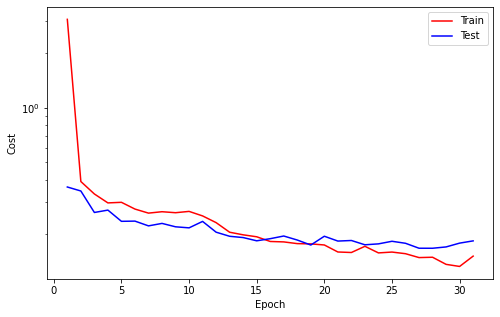

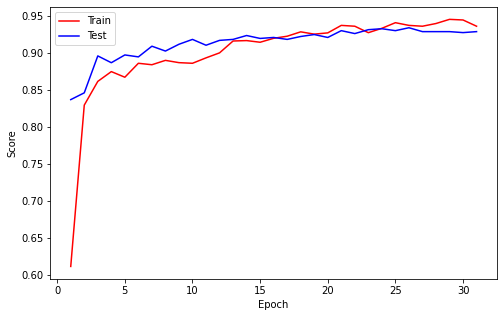

In [72]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()
        
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("val", val_set, valloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Evaluasi Model

### Confusion Matrix Val

              precision    recall  f1-score   support

    Covid-19       0.90      0.96      0.93       249
      Normal       0.94      0.87      0.90       253
   Pneumonia       0.96      0.97      0.97       259

    accuracy                           0.93       761
   macro avg       0.93      0.93      0.93       761
weighted avg       0.94      0.93      0.93       761



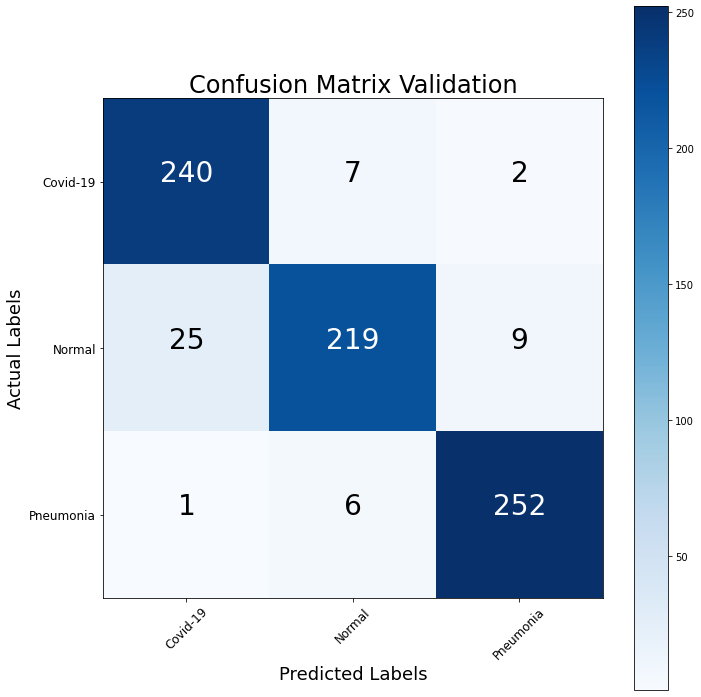

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('Actual Labels', fontsize=18)
    plt.xlabel('Predicted Labels',fontsize=18)

    
# Graphical analytics
def predictionsplot_val(model, device, valloader):
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = predictionsplot_val(model, device, valloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix Validation', fontsize=24)
plot_confusion_matrix(cm, names)
plt.savefig("/content/VGG16-Covid/plot_cm_val.png")

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "/content/VGG16-Covid/report_val.pth")
print(report)

### Confusion Matrix Testing + Model


              precision    recall  f1-score   support

    Covid-19       0.94      0.98      0.96       250
      Normal       0.95      0.93      0.94       253
   Pneumonia       1.00      0.97      0.98       259

    accuracy                           0.96       762
   macro avg       0.96      0.96      0.96       762
weighted avg       0.96      0.96      0.96       762



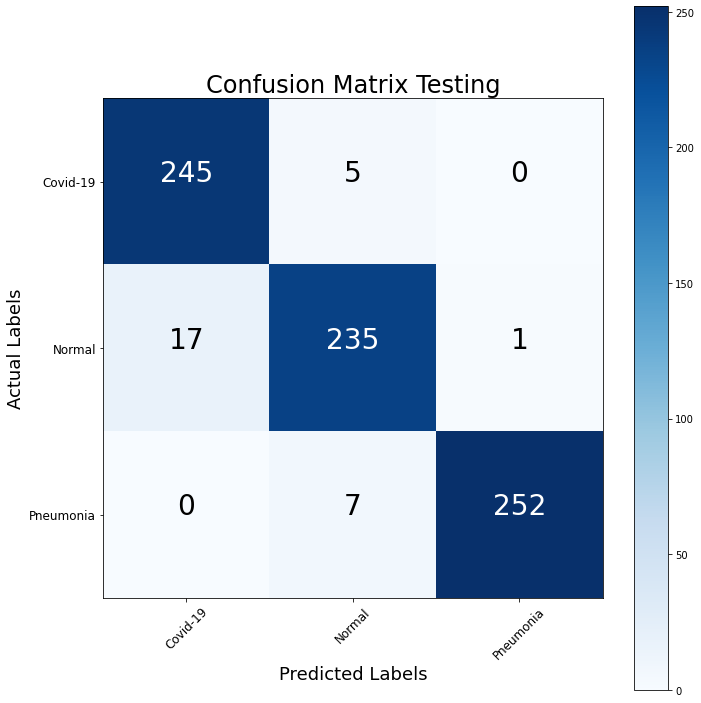

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('Actual Labels', fontsize=18)
    plt.xlabel('Predicted Labels',fontsize=18)
    
def predictions(model, device, testloader):
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = predictions(model, device, testloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix Testing', fontsize=24)
plot_confusion_matrix(cm, names)
plt.savefig("/content/VGG16-Covid/plot_cm_testing.png")

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "/content/VGG16-Covid/report_testing.pth")
print(report)

### ROC PLOT Testing

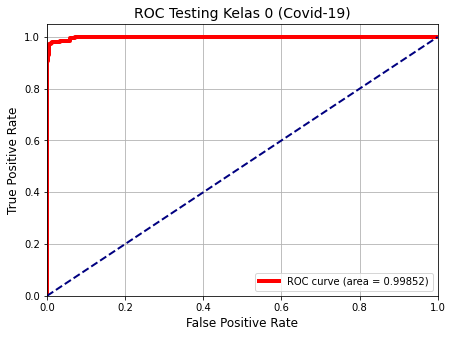

In [81]:
def test_class_probabilities(model, device, testloader, which_class):
    model.eval()
    actuals_test = []
    probabilities = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals_test.extend(labels.view_as(prediction) == which_class)
            probabilities.extend((output[:, which_class]))
    return [i.item() for i in actuals_test], [i.item() for i in probabilities]

which_class = 0 #[0,1,2] >> kelas yang mana??
actuals_test, class_probabilities = test_class_probabilities(model, device, testloader, which_class)

fpr_test, tpr_test, _ = roc_curve(actuals_test, class_probabilities)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))

plt.plot(fpr_test, tpr_test, color='red',lw=4, label='ROC curve (area = %0.5f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Testing Kelas 0 (Covid-19)', fontsize=14)
plt.legend(loc="lower right")
plt.grid('on')

plt.savefig("/content/VGG16-Covid/roc_class_test_0.png")
plt.show()

### ROC Plot Validation

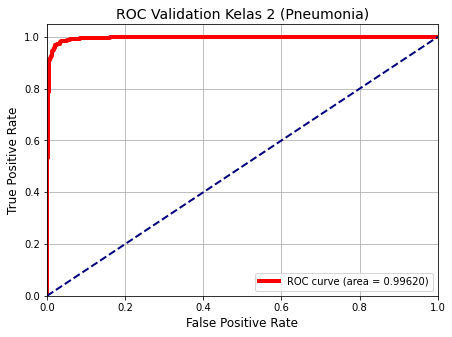

In [76]:
def test_class_probabilities(model, device, valloader, which_class):
    model.eval()
    actuals_test = []
    probabilities = []
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals_test.extend(labels.view_as(prediction) == which_class)
            probabilities.extend((output[:, which_class]))
    return [i.item() for i in actuals_test], [i.item() for i in probabilities]

which_class = 2 #[0,1,2] >> kelas yang mana??
actuals_test, class_probabilities = test_class_probabilities(model, device, valloader, which_class)

fpr_test, tpr_test, _ = roc_curve(actuals_test, class_probabilities)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))

plt.plot(fpr_test, tpr_test, color='red',lw=4, label='ROC curve (area = %0.5f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Validation Kelas 2 (Pneumonia)', fontsize=14)
plt.legend(loc="lower right")
plt.grid('on')

plt.savefig("/content/VGG16-Covid/roc_class_valid_2.png")
plt.show()

## Load Model

In [ ]:
weights = torch.load("model/covid/model-VGG16/model/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)
model = model.to(device)

## Prediction

In [ ]:
images, labels = next(iter(valloader))
images, labels = images.to(device), labels.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)
preds

tensor([1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 2, 1, 0, 1, 1,
        2, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 1, 0,
        2, 1, 0, 0, 2, 0, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2, 0, 1, 1, 2, 2,
        2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 0, 0,
        2, 0, 0, 1, 2, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2,
        0, 1, 2, 0, 1, 0, 2, 1], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

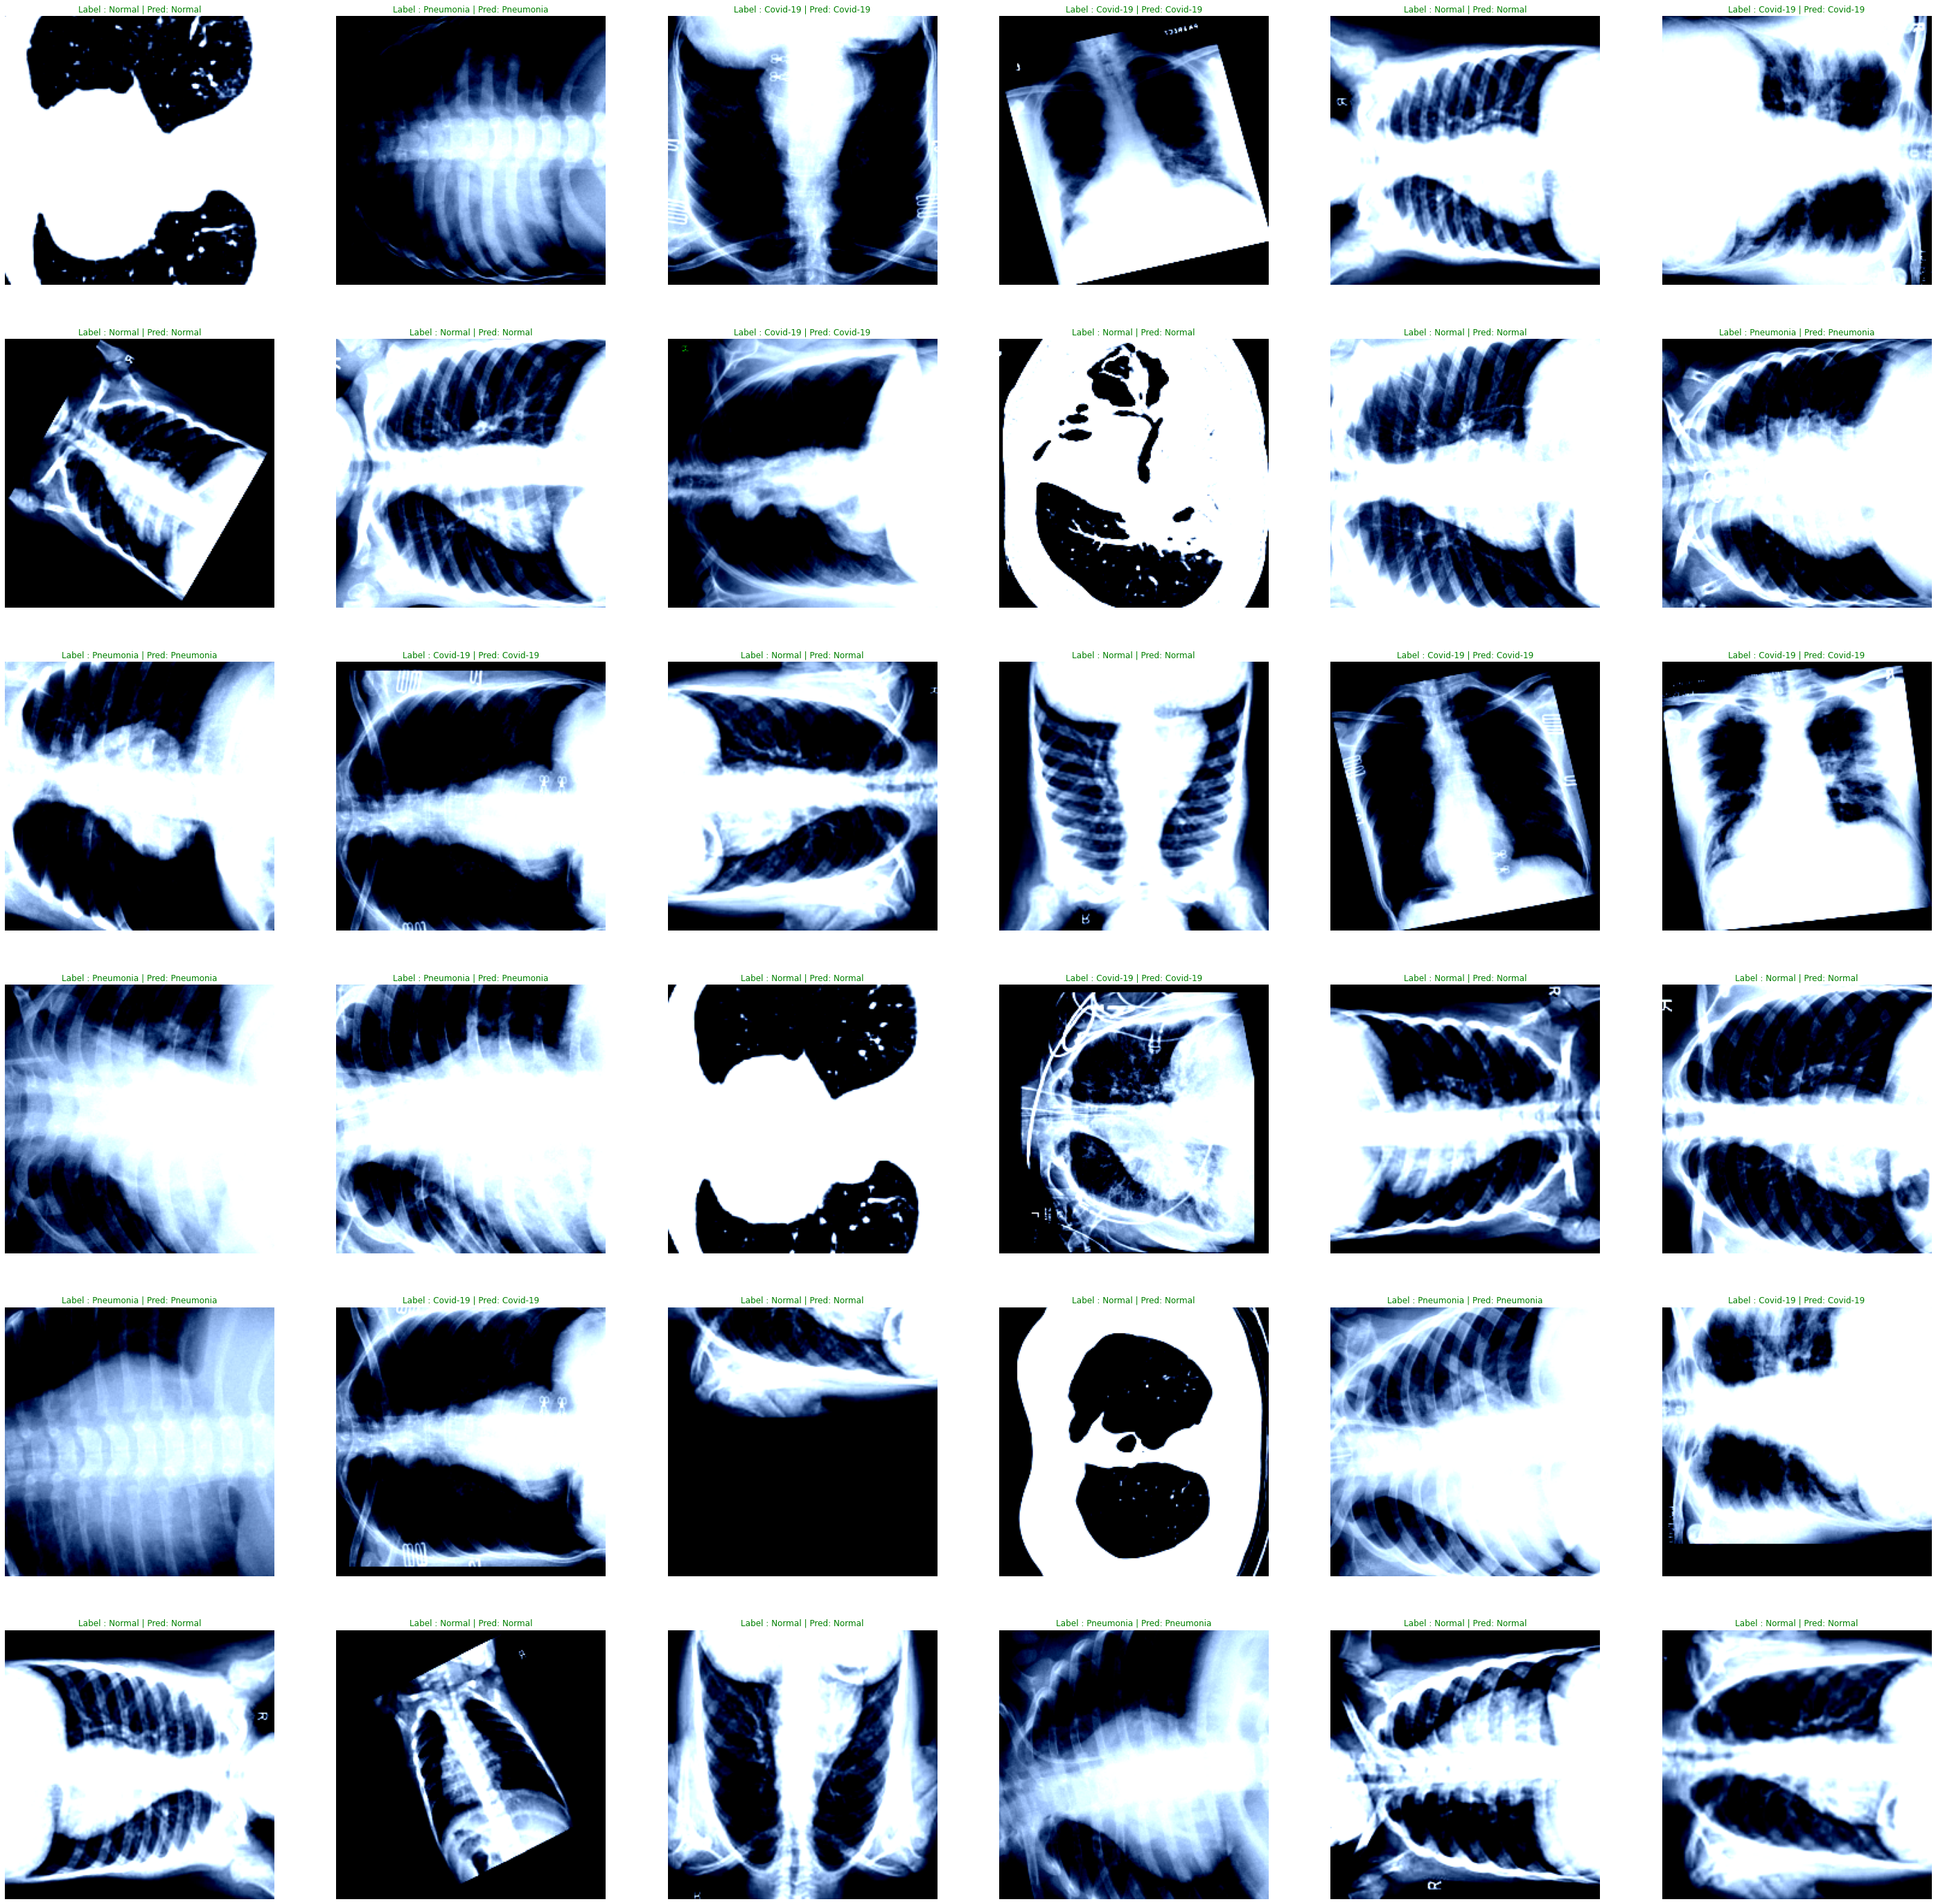

In [ ]:
fig, axes = plt.subplots(6,6, figsize=(50, 50))
for img, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    font = {"color" : "g"} if label == pred else {"color":"r"}
    
    ax.imshow(img.permute(2, 1, 0).cpu(), cmap='gray')
    font = {"color" : "g"} if label == pred else {"color":"r"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label : {label} | Pred: {pred}", fontdict=font)
    ax.axis("off");

## Save in Zip

In [ ]:
!zip -r model-VGG16PART.zip /content/VGG16-Covid

  adding: content/VGG16-Covid/ (stored 0%)
  adding: content/VGG16-Covid/weights_best.pth